# NLP - Machine Learning Classifiers[spam/ham]

### Agenda

 1. Read data(Spam/Ham data)
 2. Pre-processing: Implementing a pipeline to clean text
     - **Remove punctuation**
     - **Tokenization**
     - **Remove stopwords**
     - **Stem/Lemmatize**
 3. Feature Engineering
     - Feature Creation
     - Feature Transformation
 4. Split data
 5. Data Vectorization
 6. Machine Larening Models
     - Random Forest Classifier
     - Random Forest with Grid Search
     - Gradient Bossting Classifier
     - Gradient Boosting with Grid Search
 7. Final Evaluation of Models
 8. Conclusion

In [1]:
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

### Read Data

In [2]:
pd.set_option('display.max_colwidth', 100)
data = pd.read_csv("SMSSpamCollection.tsv", sep='\t', header=None)
data.columns = ['label', 'body_text']

data.head()

,label,body_text
0,ham,I've been searching for the right words to thank you for this breather. I promise i wont take yo...
1,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
2,ham,"Nah I don't think he goes to usf, he lives around here though"
3,ham,Even my brother is not like to speak with me. They treat me like aids patent.
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!


### Clean Text with NLTK : Function to remove punctuation, tokenize, remove stopwords, and stem
Cleaning up the text data is necessary to highlight attributes that we want our machine learning system to pick up on. 

In [3]:
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation]) ## Remove punctuation
    tokens = re.split('\W+', text) ## Tokenization
    text = [ps.stem(word) for word in tokens if word not in stopwords] ## Removeing stop words and stemming
    return text

data['clean_text'] = data['body_text'].apply(lambda x: clean_text(x))

data.head()

,label,body_text,clean_text
0,ham,I've been searching for the right words to thank you for this breather. I promise i wont take yo...,"[ive, search, right, word, thank, breather, promis, wont, take, help, grant, fulfil, promis, won..."
1,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,"[free, entri, 2, wkli, comp, win, fa, cup, final, tkt, 21st, may, 2005, text, fa, 87121, receiv,..."
2,ham,"Nah I don't think he goes to usf, he lives around here though","[nah, dont, think, goe, usf, live, around, though]"
3,ham,Even my brother is not like to speak with me. They treat me like aids patent.,"[even, brother, like, speak, treat, like, aid, patent]"
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,"[date, sunday]"


In [4]:
data.drop(['clean_text'], axis=1, inplace=True)

### Feature Engineering: Feature Creation
- Create feature for text message length
- Create feature for % of text that is punctuation

In [5]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
data['punct_percent'] = data['body_text'].apply(lambda x: count_punct(x))

In [6]:
data.head()

,label,body_text,body_len,punct_percent
0,ham,I've been searching for the right words to thank you for this breather. I promise i wont take yo...,160,2.5
1,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,128,4.7
2,ham,"Nah I don't think he goes to usf, he lives around here though",49,4.1
3,ham,Even my brother is not like to speak with me. They treat me like aids patent.,62,3.2
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,28,7.1


#### Plot new features

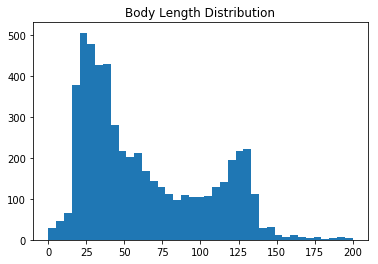

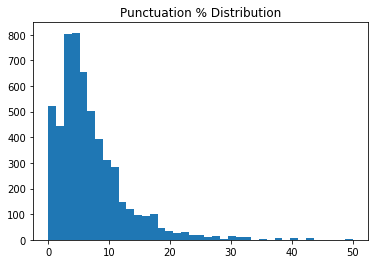

In [7]:
from matplotlib import pyplot
import numpy as np
%matplotlib inline

bins = np.linspace(0, 200, 40)
pyplot.hist(data['body_len'], bins)
pyplot.title("Body Length Distribution")
pyplot.show()

bins = np.linspace(0, 50, 40)
pyplot.hist(data['punct_percent'], bins)
pyplot.title("Punctuation % Distribution")
pyplot.show()

#### Transform the % feature

Transformation of data can be used when values are skewed left or right. Result wil be norlized values as shown in below plot
##### Box-Cox Power Transformation

**Base Form**: $$ y^x $$

| X    | Base Form           |           Transformation               |
|------|--------------------------|--------------------------|
| -2   | $$ y ^ {-2} $$           | $$ \frac{1}{y^2} $$      |
| -1   | $$ y ^ {-1} $$           | $$ \frac{1}{y} $$        |
| -0.5 | $$ y ^ {\frac{-1}{2}} $$ | $$ \frac{1}{\sqrt{y}} $$ |
| 0    | $$ y^{0} $$              | $$ log(y) $$             |
| 0.5  | $$ y ^ {\frac{1}{2}}  $$ | $$ \sqrt{y} $$           |
| 1    | $$ y^{1} $$              | $$ y $$                  |
| 2    | $$ y^{2} $$              | $$ y^2 $$                |


**Process**
1. Determine what range of exponents to test
2. Apply each transformation to each value of your chosen feature
3. Use some criteria to determine which of the transformations yield the best distribution

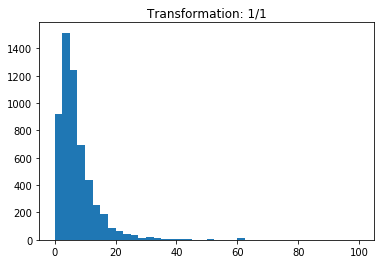

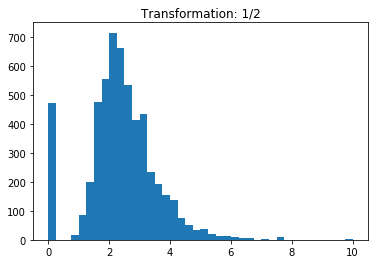

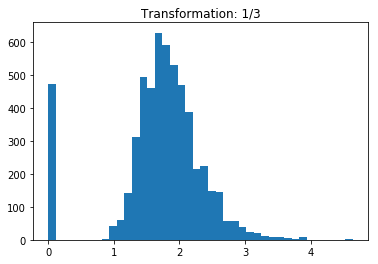

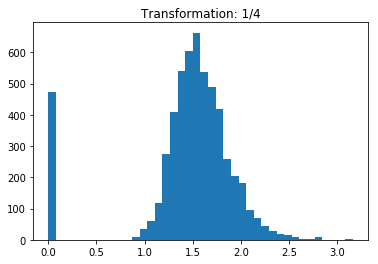

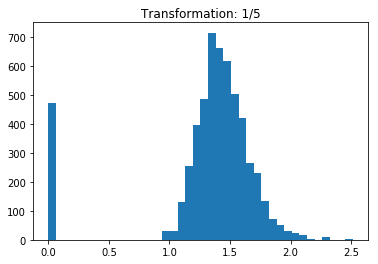

In [8]:
for i in [1,2,3,4,5]:
    pyplot.hist((data['punct_percent'])**(1/i), bins=40)
    pyplot.title("Transformation: 1/{}".format(str(i)))
    pyplot.show()

We can use 4th or 5th trnasform based on our convenience 

### Split data train/test

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['body_text', 'body_len', 'punct_percent']], data['label'], test_size=0.2)

### Vectorization of Raw Data

We have several vectorization methods like Word Count vectorization, N-Gram, Skip-Gram and TF-IDF.
We follow any one and here we go with TF-IDF.

**TF-IDF:**  Creates a document-term matrix where the columns represent single unique terms (unigrams) but the cell represents a weighting meant to represent how important a word is to a document.
                
                TFIDF = (tf)*log(N/df)
                
     tf = number of times the word occur in a doument divided by total number of words in document
     N  = Total number of document
     df = number of documents the word precent in

In [10]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

tfidf_train = tfidf_vect_fit.transform(X_train['body_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['body_text'])

X_train_vect = pd.concat([X_train[['body_len', 'punct_percent']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct_percent']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,body_len,punct_percent,0,1,2,3,4,5,6,7,...,7261,7262,7263,7264,7265,7266,7267,7268,7269,7270
0,115,2.6,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23,8.7,0.385337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,43,2.3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,101,4.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,74,2.7,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Building Machine Learning Classifiers

In [11]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import time

### Explore RandomForestClassifier Attributes & Hyperparameters

In [12]:
print(dir(RandomForestClassifier))
print(RandomForestClassifier())

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_cache', '_abc_negative_cache', '_abc_negative_cache_version', '_abc_registry', '_estimator_type', '_get_param_names', '_make_estimator', '_set_oob_score', '_validate_X_predict', '_validate_estimator', '_validate_y_class_weight', 'apply', 'decision_path', 'feature_importances_', 'fit', 'get_params', 'predict', 'predict_log_proba', 'predict_proba', 'score', 'set_params']
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0,

In [18]:
from sklearn.model_selection import KFold, cross_val_score

tfidf_vect_RF = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vect_RF.fit_transform(data['body_text'])
X_features = pd.concat([data['body_len'], data['punct_percent'], pd.DataFrame(X_tfidf.toarray())], axis=1)

rf = RandomForestClassifier(n_jobs=-1)
k_fold = KFold(n_splits=5)
cross_val_score(rf, X_features, data['label'], cv=k_fold, scoring='accuracy', n_jobs=-1)

array([0.97576302, 0.97396768, 0.97217235, 0.95148248, 0.96765499])

### Grid search with Random Forest

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_features, data['label'], test_size=0.2)

def train_RF(n_est, depth):
    rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, n_jobs=-1)
    rf_model = rf.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    precision, recall, fscore, support = score(y_test, y_pred, pos_label='spam', average='binary')
    print('Est: {} / Depth: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
        n_est, depth, round(precision, 3), round(recall, 3),
        round((y_pred==y_test).sum() / len(y_pred), 3)))

In [21]:
for n_est in [10, 50, 100]:
    for depth in [10, 20, 30, None]:
        train_RF(n_est, depth)

Est: 10 / Depth: 10 ---- Precision: 1.0 / Recall: 0.292 / Accuracy: 0.898
Est: 10 / Depth: 20 ---- Precision: 1.0 / Recall: 0.547 / Accuracy: 0.934
Est: 10 / Depth: 30 ---- Precision: 1.0 / Recall: 0.727 / Accuracy: 0.961
Est: 10 / Depth: None ---- Precision: 0.986 / Recall: 0.857 / Accuracy: 0.978
Est: 50 / Depth: 10 ---- Precision: 1.0 / Recall: 0.23 / Accuracy: 0.889
Est: 50 / Depth: 20 ---- Precision: 1.0 / Recall: 0.59 / Accuracy: 0.941
Est: 50 / Depth: 30 ---- Precision: 1.0 / Recall: 0.752 / Accuracy: 0.964
Est: 50 / Depth: None ---- Precision: 0.993 / Recall: 0.826 / Accuracy: 0.974
Est: 100 / Depth: 10 ---- Precision: 1.0 / Recall: 0.199 / Accuracy: 0.884
Est: 100 / Depth: 20 ---- Precision: 1.0 / Recall: 0.584 / Accuracy: 0.94
Est: 100 / Depth: 30 ---- Precision: 1.0 / Recall: 0.758 / Accuracy: 0.965
Est: 100 / Depth: None ---- Precision: 1.0 / Recall: 0.839 / Accuracy: 0.977


### Explore GradientBoostingClassifier Attributes & Hyperparameters

In [22]:
print(dir(GradientBoostingClassifier))
print(GradientBoostingClassifier())

['_SUPPORTED_LOSS', '__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_cache', '_abc_negative_cache', '_abc_negative_cache_version', '_abc_registry', '_check_initialized', '_check_params', '_clear_state', '_decision_function', '_estimator_type', '_fit_stage', '_fit_stages', '_get_param_names', '_init_decision_function', '_init_state', '_is_initialized', '_make_estimator', '_resize_state', '_staged_decision_function', '_validate_estimator', '_validate_y', 'apply', 'decision_function', 'feature_importances_', 'fit', 'get_params', 'n_features', 'predict', 'predict_log_proba', 'predict_proba', 'score', 's

In [23]:
def train_GB(est, max_depth, lr):
    gb = GradientBoostingClassifier(n_estimators=est, max_depth=max_depth, learning_rate=lr)
    gb_model = gb.fit(X_train, y_train)
    y_pred = gb_model.predict(X_test)
    precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
    print('Est: {} / Depth: {} / LR: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
        est, max_depth, lr, round(precision, 3), round(recall, 3), 
        round((y_pred==y_test).sum()/len(y_pred), 3)))

In [24]:
for n_est in [50, 100, 150]:
    for max_depth in [3, 7, 11, 15]:
        for lr in [0.01, 0.1, 1]:
            train_GB(n_est, max_depth, lr)

C:\Users\s.mudalapuram\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Est: 50 / Depth: 3 / LR: 0.01 ---- Precision: 0.0 / Recall: 0.0 / Accuracy: 0.855
Est: 50 / Depth: 3 / LR: 0.1 ---- Precision: 0.974 / Recall: 0.702 / Accuracy: 0.954
Est: 50 / Depth: 3 / LR: 1 ---- Precision: 0.969 / Recall: 0.77 / Accuracy: 0.963
Est: 50 / Depth: 7 / LR: 0.01 ---- Precision: 1.0 / Recall: 0.012 / Accuracy: 0.857
Est: 50 / Depth: 7 / LR: 0.1 ---- Precision: 0.925 / Recall: 0.839 / Accuracy: 0.967
Est: 50 / Depth: 7 / LR: 1 ---- Precision: 0.937 / Recall: 0.832 / Accuracy: 0.968
Est: 50 / Depth: 11 / LR: 0.01 ---- Precision: 1.0 / Recall: 0.006 / Accuracy: 0.856
Est: 50 / Depth: 11 / LR: 0.1 ---- Precision: 0.946 / Recall: 0.863 / Accuracy: 0.973
Est: 50 / Depth: 11 / LR: 1 ---- Precision: 0.894 / Recall: 0.839 / Accuracy: 0.962
Est: 50 / Depth: 15 / LR: 0.01 ---- Precision: 1.0 / Recall: 0.006 / Accuracy: 0.856
Est: 50 / Depth: 15 / LR: 0.1 ---- Precision: 0.944 / Recall: 0.845 / Accuracy: 0.97
Est: 50 / Depth: 15 / LR: 1 ---- Precision: 0.916 / Recall: 0.876 / Accura


### Final evaluation of models
#### Random Forest 
Random Forest is better performed with 150 estimaters and max_depth none. We use the same in final evaluation. We can run Random Forest in parallel with n_jobs = -1

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data[['body_text', 'body_len', 'punct_percent']], data['label'], test_size=0.2)

In [26]:
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

start = time.time()
rf_model = rf.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = rf_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 66.673 / Predict time: 0.865 ---- Precision: 0.125 / Recall: 0.029 / Accuracy: 0.855


#### Gradient Boosting 
Gradient Boosting is better performed with 150 estimaters, max_depth=11 and Learning rate 0.1 as itsa default value based on grid search method. We go with same parametric values in final estiamtion.

In [27]:
gb = GradientBoostingClassifier(n_estimators=150, max_depth=11)

start = time.time()
gb_model = gb.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = gb_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 554.702 / Predict time: 0.344 ---- Precision: 0.14 / Recall: 0.043 / Accuracy: 0.848


### Conclution

Based on results from coparision, Random Forest performes better over Gradient Booting in terms of Precission and Accuracy. But Gradient Boosting performed better over Random Forest in terms of Recall.

Time consuming is more for Gradient Boosting classifier and its costly over Random Forest classifier.

So, which on is suitble? Its depends on the our Business case. If business needs better Recall values, we shoould go with Gradient Booting else we go with Random Forest.